In [2]:
import pandas as pd

# Plot graphs
%matplotlib inline
import altair as alt
alt.renderers.enable('notebook')


#Quick EDA
import pandas_profiling

#Time series forcasting
from fbprophet import Prophet

#Apriori algorithm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile

import os

import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [3]:
path = './data'
file_name = os.path.join(path, 'jira_clean.tsv.zip')
#Load the zip file
zip_file = ZipFile(file_name)

for text_file in zip_file.infolist():
       if text_file.filename == 'jira_clean.tsv':
            print('reading data....', text_file.filename)
            #Creating data frame
            data_df = pd.read_csv(zip_file.open(text_file.filename), sep='\t', header=None, 
                        names=['date', 'unix_time','instance','product','username', 'event', 'attributes'],
                        parse_dates=['date']).set_index('date')

reading data.... jira_clean.tsv


In [4]:
data_df.head()

,unix_time,instance,product,username,event,attributes
date,,,,,,
2014-12-01 16:00:02.153,1417410002153,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,quickbrowse,{'issueKey': 'eaf34eb91618cf3e1bf487a822a2cce6'}
2014-12-01 16:00:07.691,1417410007691,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,kickass.criteriaAutoUpdateEnabled,{'context_pageTime': '6ce628243b670aff9f549029...
2014-12-01 16:00:07.691,1417410007691,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,kickass.viewIssue,{'context_pageSession': 'a09b1242b4712e1cb23bf...
2014-12-01 16:00:07.691,1417410007691,3998740a9e4924af7feedeb2e04190f6,jira,d50d63ec8ecdf32d1dd9ae4a0cecd2f8,browserWindowSize,"{'width': '00409424d52c3a1a30e98cd1cd91638a', ..."
2014-12-01 16:00:10.523,1417410010523,c93da7e17688ef90fc43963b5a6c6259,jira,2cc91ff23ca6213e8a7d2513a31d8fa8,lexorankbalance,{'fieldId': '4537ecbd3f85c18825157673510a445d'...


## Describe the data set in broad strokes.  Note down any data anomalies, outliers or anything you think is unusual in the data set.


In [5]:
pandas_profiling.ProfileReport(data_df.reset_index(), check_correlation=False)

Number of variables,7
Number of observations,592458
Total Missing (%),0.0%
Total size in memory,31.6 MiB
Average record size in memory,56.0 B
Numeric,1
Categorical,4
Boolean,0
Date,1
Text (Unique),0
Rejected,1


### Drop duplicates

In [6]:
data_df.drop_duplicates(inplace=True)
data_df = data_df.drop(['unix_time', 'product'], axis=1)

## Plot a trend of the number of daily active users (DAU) for this data set. What jumps out at you from this trend?


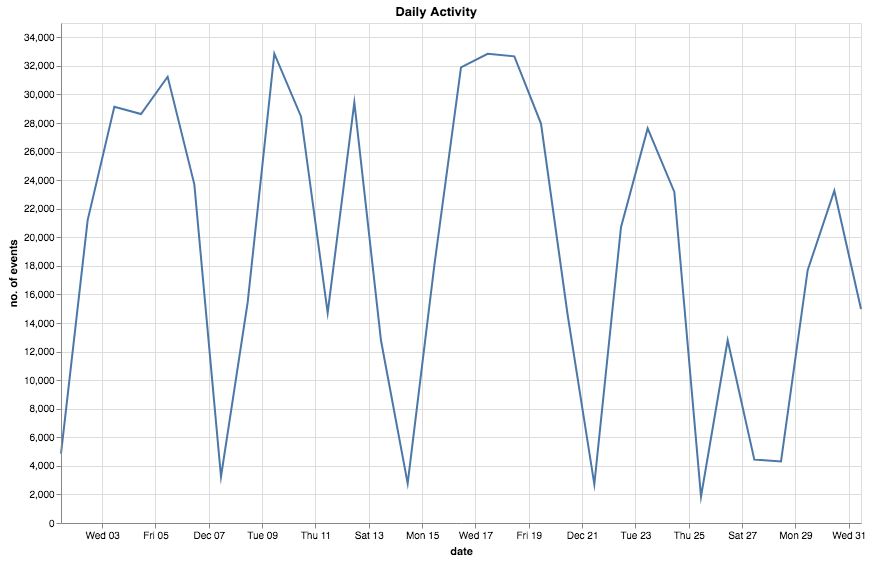

In [7]:
_ = data_df.groupby([pd.Grouper(freq='D')]).size().rename('events').reset_index()
alt.Chart(_).mark_line().encode(
    x='date:T',
    y=alt.Y('events:Q', title='no. of events'),
).properties(title='Daily Activity', width=800, height=500)

### No. of events per day per instance

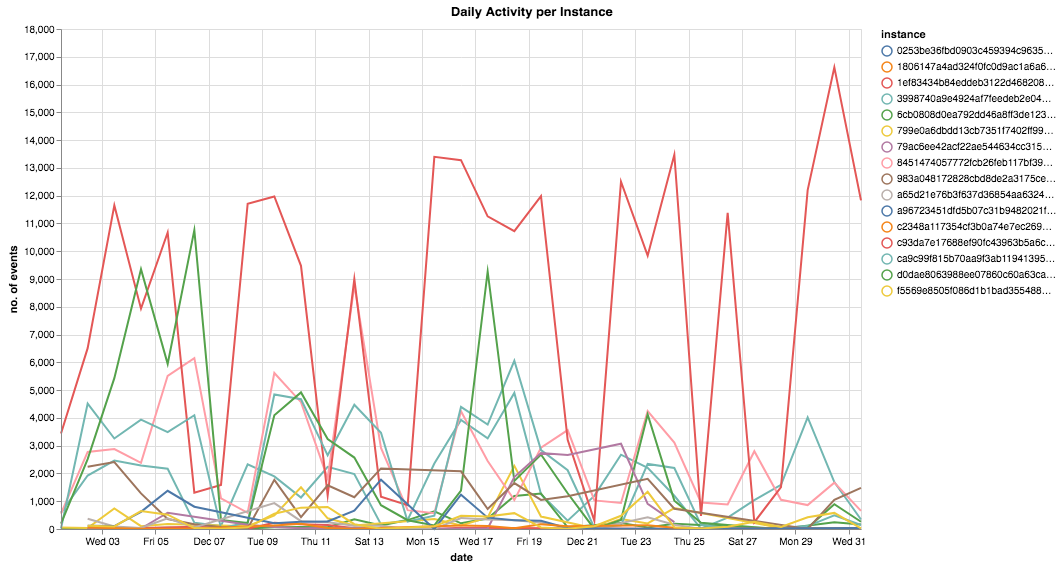

In [8]:
_ = data_df.groupby([pd.Grouper(freq='D'), 'instance']).size().reset_index()
_.columns = ['date', 'instance', 'count']
alt.Chart(_).mark_line().encode(
    x='date:T',
    y=alt.Y('count:Q', title='no. of events'),
    color='instance'
).properties(title='Daily Activity per Instance', width=800, height=500)

### Trend of daily active users
Prophet package for time series forcasting is used here to analyse the activity. It will split the time series into
its components including the trend. From the trend we can see the number of active users is dropping towards the
year end.

In [10]:
username_day_df = data_df.groupby([pd.Grouper(freq='D'), 'username']).size().groupby(level=0).size().reset_index()
username_day_df.columns = ['ds','y']

print(username_day_df.head())
#daily_seasonality=True
m = Prophet()
m.fit(username_day_df)

future = m.make_future_dataframe(periods=5)
forecast = m.predict(future)

print('Forecast next 5 days')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


          ds    y
0 2014-12-01   78
1 2014-12-02  202
2 2014-12-03  213
3 2014-12-04  211
4 2014-12-05  208
Forecast next 5 days


,ds,yhat,yhat_lower,yhat_upper
31,2015-01-01,114.168304,74.097820,157.227657
32,2015-01-02,120.290225,76.116761,159.025812
33,2015-01-03,52.302145,9.784611,92.618560
34,2015-01-04,-9.432699,-51.000110,33.244416
35,2015-01-05,55.893655,17.705608,97.675819


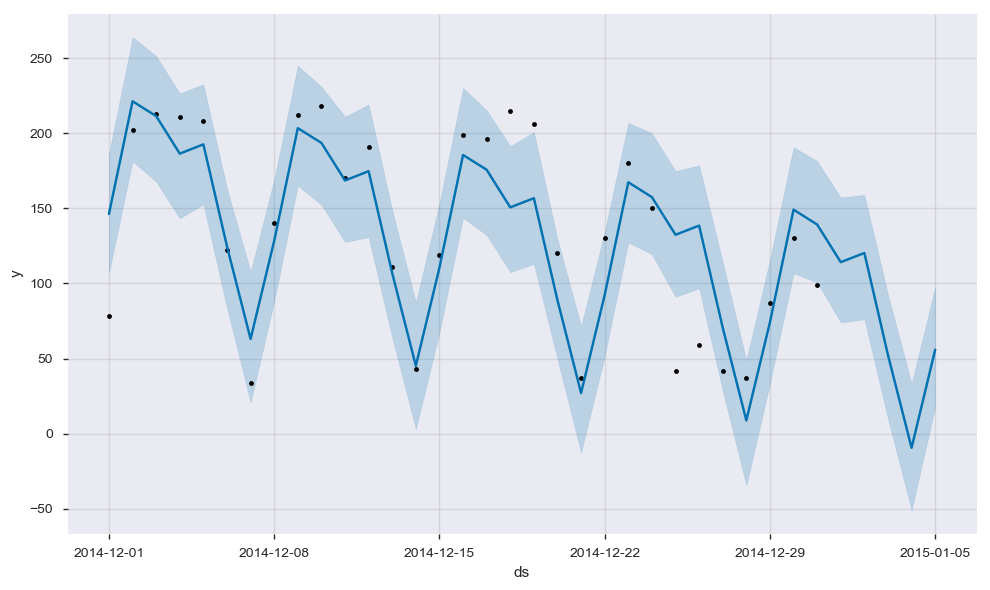

In [11]:
forcast_fig = m.plot(forecast)

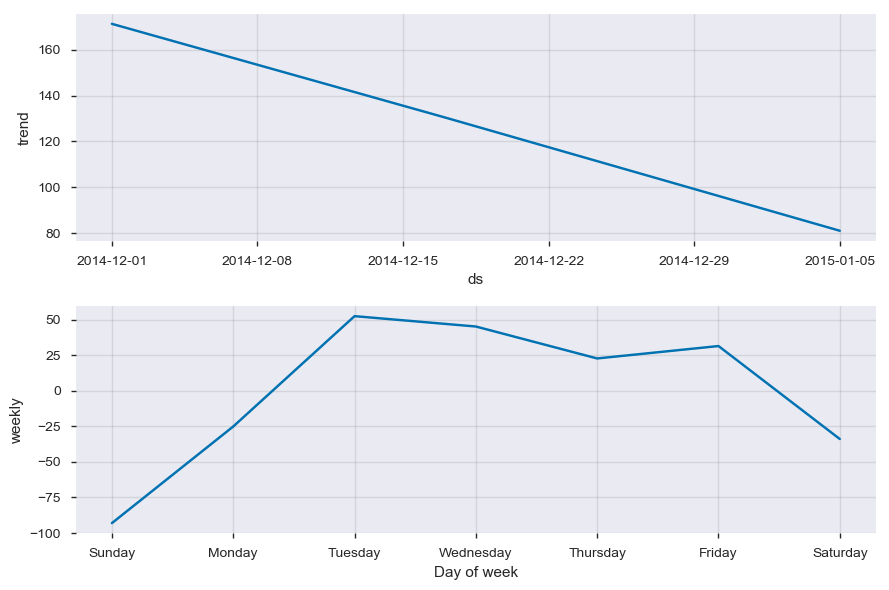

In [12]:
trend_fig = m.plot_components(forecast)

## What is the average usage of "dashboardview" per user per day, when they are active in the product? What is the proportion of users who triggered "dashboardview" during the month of December 2014? Quantify the margin of error of your estimate.


### Average usage of "dashboardview" per user per day

In [13]:
dash_df = data_df.loc[data_df.event.str.contains('dashboardview')].groupby(['username']).size()/31.
dash_df.sort_values(ascending=False).head()

username
2cc91ff23ca6213e8a7d2513a31d8fa8    19.870968
60149f599d63527fbc8837f46432c784     6.935484
5058c6eaa55616594dd10e71a4e88f02     6.064516
87045a1ae8f130e18cf8963b54c7e665     5.870968
086c5874375d40b39ccaea2713a568be     5.806452
dtype: float64

### What is the proportion of users who triggered "dashboardview" during the month of December 2014?

In [14]:
len(data_df.loc[data_df.event.str.contains('dashboardview')]['username'].unique())/len(data_df.username.unique())

0.6406570841889117

## Compare users "778251ffec35de6bbbb089198b9ac516" and "7e7a085a9f6f55253b2aa15dbcb702a8" from the instance "c93da7e17688ef90fc43963b5a6c6259"; would you conclude their average number of events per day to be different? Justify your answer.

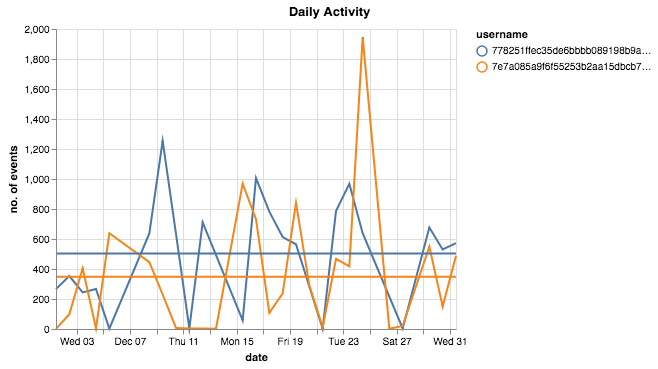

In [15]:
#Get the events for these two users
_instance = 'c93da7e17688ef90fc43963b5a6c6259'
_user1 = '778251ffec35de6bbbb089198b9ac516'
_user2 = '7e7a085a9f6f55253b2aa15dbcb702a8'

user_events_df = data_df[(data_df['instance']==_instance)\
                   & ((data_df['username']==_user1) |\
                     (data_df['username']==_user2))]\
                   .groupby([pd.Grouper(freq='D'),'username'])['event'].count().rename('event_count').reset_index()


main = alt.Chart(user_events_df).mark_line().encode(
    x='date:T',
    y=alt.Y('event_count:Q', title='no. of events'),
    color='username'
).properties(title='Daily Activity')

rule = alt.Chart(user_events_df).mark_rule(color='red').encode(
    y='mean(event_count)',
    color='username',
    size=alt.value(2)
)

main + rule

## Our users tend to use multiple features together when they use our products. Cluster events that tend to appear together into groups, and explain how and why you have clustered events in such a way.

#### I suggest Apriori Algorithm to find the groups of features. So the features selected by a user will be like a transaction and the features used like the elements of the transaction. Then, the Apriori algorithm will find which features come togather. We can play with the thresholds to select the groups.

In [16]:
#Reformatting the data frame
_ = data_df
_['cnt'] = 1
pivoted_df = _.pivot_table(index='username', columns='event', values='cnt', aggfunc="sum",fill_value=0)

In [17]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

pivoted_df = pivoted_df.applymap(encode_units)

In [18]:
frequent_itemsets = apriori(pivoted_df, min_support=0.4, use_colnames=True)

In [19]:
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

In [20]:
frequent_itemsets.to_csv('./item_set.csv')

In [21]:
ls

Alta.ipynb       item_set.csv     output_14_0.png  output_9_3.png
data/            notebook.tex     output_15_0.png
freq.csv         output_11_3.png  output_23_3.png
